<a href="https://colab.research.google.com/github/pyrated03/IISc-Coding-Test/blob/main/PACS_Domain_Generalization(IISc_Coding_Test)_Adarsh_Subramanian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clearing GPU memory before training

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import gc
# del variables
gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'

## MOUNTING DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


INSTALLING RESNET_PYTORCH LIBRARY

In [ ]:
!pip3 install resnet_pytorch

### UNZIPPING THR GIVEN PACS.zip DATA FILE TO USE FOR TRAINING. 
THE BELOW LINE HAS BEEN COMMENTED AS THE FILE HAS BEEN UNZIPPED AND NEED NOT BE DONE AGAIN.

In [ ]:
# !unzip gdrive/My\ Drive/IISc\ Coding\ Test/PACS.zip -d gdrive/My\ Drive/IISc\ Coding\ Test

IMPORTING NECESSARY LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid

import torchvision.transforms as T
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
from torchvision.utils import save_image    
from IPython.display import Image
import random


import torch.optim as optim
import torch.nn.functional as F
from torchvision import *
import time
import copy
from torch.optim import lr_scheduler


DEFINING NECESSARY TRANSFORMS

In [ ]:
# add transforms to the data
# some of the transformations have been commented out due to GPU constraints
data_transforms = {
    'train': transforms.Compose([
        # transforms.Grayscale(),

        # transforms.RandomRotation(45),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize((32)),#attention 
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        # transforms.Grayscale(),
        transforms.ToPILImage(),
        torchvision.transforms.ToTensor(),
        transforms.Resize((32)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # transforms.Grayscale(),
        transforms.ToPILImage(),
        torchvision.transforms.ToTensor(),
        transforms.Resize((32)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

### **DATALOADER**

In [ ]:
class MyDataset(Dataset):

    def __init__(self, train = True, transforms = None):
        
        self.transforms = transforms
        if train:
            path_p = "gdrive/My Drive/IISc Coding Test/kfold/photo"
            path_a = "gdrive/My Drive/IISc Coding Test/kfold/art_painting"
            path_c = "gdrive/My Drive/IISc Coding Test/kfold/cartoon"

            path_labels = os.listdir(path_p)
            self.label_dict = {}
            i = 0
            for l in path_labels:
                self.label_dict[l] = i
                i+=1

            # print(path_labels)
            self.images_label_dict = {}

            for label in path_labels:
                path_1 = os.listdir(path_p+"/"+label)
                # count+=len(path_1)
                path_2 = os.listdir(path_a+"/"+label)
                # count+=len(path_2)
                path_3 = os.listdir(path_c+"/"+label)
                # count+=len(path_3)

                for path_img in path_1:
                    path_img = path_p+"/"+label+"/"+path_img
                    self.images_label_dict[path_img] = label 

                for path_img in path_2:
                    path_img = path_a+"/"+label+"/"+path_img
                    self.images_label_dict[path_img] = label

                for path_img in path_3:
                    path_img = path_c+"/"+label+"/"+path_img
                    self.images_label_dict[path_img] = label

        else:
            path_test = "gdrive/My Drive/IISc Coding Test/kfold/sketch"
            path_labels = os.listdir(path_test)
            self.label_dict = {}
            i = 0
            for l in path_labels:
                self.label_dict[l] = i
                i+=1

            # print(path_labels)
            self.images_label_dict = {}

            for label in path_labels:
                path_1 = os.listdir(path_test+"/"+label)

                for path_img in path_1:
                    path_img = path_test+"/"+label+"/"+path_img
                    self.images_label_dict[path_img] = label 
       
    def __getitem__(self, index):
        keys = list(self.images_label_dict.keys())
        values = list(self.images_label_dict.values())
        image = read_image(keys[index])
        label = self.label_dict[values[index]]

        # sample = {'x':image, 'y':label}
        # return sample
        if self.transforms:
          image = self.transforms(image)

        return image,label

    def __len__(self):
        return len(self.images_label_dict)

LOADING TRAIN(SOURCE) DATA AND SPLITTING 10% OF IT FOR VALIDATION

In [ ]:
class_size = 7

In [ ]:
dset = MyDataset(train=True, transforms = data_transforms['train'])
batch_size = 32
validation_split = 0.1 #10% of source domain kept as validation set
shuffle_dataset = True
random_seed= 42

from torch.utils.data.sampler import SubsetRandomSampler

dataset_size = len(dset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_ds = DataLoader(dset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
dset = MyDataset(train=True, transforms = data_transforms['valid'])
validation_ds = DataLoader(dset, batch_size=batch_size, sampler=valid_sampler,drop_last=True)


LOADING TEST(TARGET) DATA

In [ ]:
test_dset = MyDataset(train = False, transforms = data_transforms['test'])
batch_size = 32
random_seed= 42

test_ds = DataLoader(test_dset, batch_size=batch_size, drop_last=True)

In [ ]:
dataset_sizes = {'train' : len(train_ds)*batch_size, 'valid' : len(validation_ds)*batch_size, 'test' : len(test_ds)*batch_size}
print(len(train_ds))
print(len(validation_ds))
print(len(test_ds))


170
18
122


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

### **DEFINING RESNET-18 AS THE FEATURE EXTRACTOR**

In [ ]:
model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### **DEFINING THE FINAL LAYER FOR CLASSIFICATION**

In [ ]:
model.fc = nn.Sequential(nn.Linear(512,7)) #, nn.Softmax(7))
# model
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **TRAINING AND VALIDATION, WITHOUT INCLUDING THE TESTING TERMS IN LOSS**

# **------------------------------------------------------------------------------------------------**



### **DEFINING A FUNCTION TO TRAIN THE MODEL, AND RETURN THE LOSS COMPONENTS**

In [ ]:
def train_model(model, criteria,softmax, optimizer, scheduler,device, num_epochs=25,lambda1=0.33,lambda2=0.33,lambda3=0.33):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  c_no = 0
  loss_a_array = []
  loss_b_array = []
  loss_c_array = []
  for epoch in range(1, num_epochs+1):
    bol = True  
    print('Epoch {}/{}'.format(epoch, num_epochs ))
    print('-' * 10)
    iter = 0
    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase == 'train':
        scheduler.step()
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode
      # loss_a_total = 0.0
      running_loss = 0.0
      running_corrects = 0
      running_corrects_valid = 0
      loss = torch.zeros(batch_size,class_size, requires_grad=True).to(device)
      # Iterate over data.
      if phase == 'train':
        for inputs, labels in train_ds:
          iter+=1
          print('Iterations :', iter)
          # print("Inside Train")
          inputs = inputs.float().to(device)
          labels = labels.to(device)
          # print(inputs.shape)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          bol = True
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss_a = criteria(outputs, labels)
            loss_b = torch.zeros(class_size,batch_size, requires_grad=True).to(device)
            loss_c = torch.zeros(batch_size,class_size, requires_grad=True).to(device)

          # backward + optimize only if in training phase
          if phase == 'train':
            # print("shape of loss_a",loss_a.shape)
            loss_a.backward()
            optimizer.step()
          
            # loss_a_total += loss_a
            loss_a_mean = torch.mean(loss_a)
            print(loss_a_mean)
            loss_a_array.append(loss_a_mean.item())
            running_loss += loss_a.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
      loss_a_total_mean = np.mean(loss_a_array)
      loss_a_tensor = torch.ones(loss.shape, requires_grad=True) * loss_a_total_mean
    #   iter_test = 1
    #   if phase == 'train':
    #     for inputs_test, labels_test in test_ds:
    #       print(iter_test)
    #       iter_test+=1
    #       inputs_test = inputs_test.float().to(device)
    #       # print("Input_Test shape ",inputs_test.shape)
    #       outputs_test = softmax(model(inputs_test))
    #       # print("output_test",outputs_test)
    #       # print("Output_Test shape ",outputs_test.shape)
    #       try:
    #         sigma,_ = torch.max(outputs_test,1)
    #         # print("sigma",sigma)
    #         _,ypred = torch.max(outputs_test,1)
    #         cmp = torch.ones(len(outputs_test)) * 0.95
    #         cmp = cmp.to(device)
    #         cmp = torch.ge(sigma, cmp)
    #         # print("cmp",cmp)
    #         loss_b =torch.mul(torch.mul(sigma, criteria(outputs_test, ypred)),cmp)
    #         # print(loss_b)
    #         loss_b_mean = torch.mean(loss_b)
    #         loss_b_array.append(loss_b_mean.item())
    #         additive = (torch.ones(outputs_test.shape, requires_grad=True) * (10**(-9))).to(device)
    #         outputs_test = outputs_test + additive
    #         # print("output_test",outputs_test)
    #         # qwertyu = torch.log(outputs_test)
    #         # print("log of p(x)", qwertyu)
    #         loss_c = -torch.mul((outputs_test), torch.log(outputs_test))
    #         loss_c_mean = torch.mean(loss_c)
            
    #         loss_c_array.append(loss_c_mean.item())
    #         print("loss_b",loss_b_mean)
    #         print("loss_c",loss_c_mean)
    #         loss_b = torch.reshape(loss_b, (batch_size,1))
    #         loss_b = torch.cat((loss_b,loss_b,loss_b,loss_b,loss_b,loss_b,loss_b),1)
    #         # print(loss_b.shape)
    #         # loss_b_t = torch.transpose(loss_b,0,1).to(device)
    #         loss = lambda2 * loss_b + lambda3 * loss_c.to(device) #lambda1 * loss_a_tensor.to(device) + 
    #         loss = loss.float()
    #         loss_scalar = torch.mean(loss)
            

    #         with torch.set_grad_enabled(phase == 'train'):
    #           if phase == 'train':
    #             print("for loss", loss_scalar.requires_grad)
    #             loss_scalar.backward(retain_graph=True)
    #             optimizer.step()
    #       except:
    #         print("Catch in test")

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects*1.0 / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      print("No of catches: ",c_no)
      # deep copy the model
      iter_valid = 0
      if phase == 'valid':
        for inputs_valid, labels_valid in validation_ds:
          iter_valid += 1
          inputs_valid = inputs_valid.float().to(device)
          labels_valid = labels_valid.to(device)
          print("validation:",iter_valid)
          outputs_valid = model(inputs_valid)
          _, preds_valid = torch.max(outputs_valid, 1)
          running_corrects_valid += torch.sum(preds_valid == labels_valid)

        epoch_acc_valid = running_corrects_valid*1.0 / dataset_sizes[phase]
        print("Validation Accuracy: ",epoch_acc_valid)
      if phase == 'valid' and epoch_acc_valid > best_acc:
        best_acc = epoch_acc_valid
        best_model_wts = copy.deepcopy(model.state_dict())
    print()        

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,loss_a_array,loss_b_array,loss_c_array

In [ ]:
criteria = nn.CrossEntropyLoss()
softmax = nn.Softmax()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# Number of epochs
eps=10


## **TRAINING THE MODEL**

In [ ]:
model,loss_a_array,loss_b_array,loss_c_array = train_model(model, criteria,softmax, optimizer, scheduler,device, eps,0.999, 0.0005,0.0005)

Epoch 1/10
----------
Iterations : 1
tensor(2.9418, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 2


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


tensor(2.9528, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 3
tensor(3.0361, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 4
tensor(2.6118, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 5
tensor(2.5781, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 6
tensor(2.5316, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 7
tensor(2.7235, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 8
tensor(2.6117, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 9
tensor(2.0576, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 10
tensor(2.5080, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 11
tensor(2.8028, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 12
tensor(3.1537, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 13
tensor(1.9640, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 14
tensor(2.1905, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 15
tensor(2.5346, device='cuda:0', grad_fn=<MeanBackward0>)
I

### **PLOTTING THE LOSS COMPONENTS RETURNED FROM TRAINING**

LOSS A

(0,)


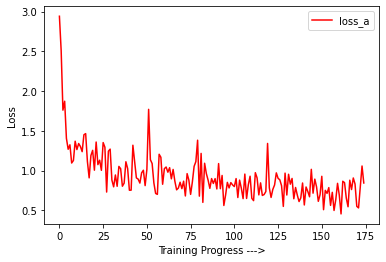

In [ ]:
lin_a = np.linspace(0, (len(loss_a_array)-1),175)
a_new_array = []
# print(loss_a_array[0])
for i in lin_a:
    # print(loss_a_array[int(i)])
    a_new_array.append(loss_a_array[int(i)])
print(np.array(loss_c_array).shape)
plt.plot(a_new_array,color = 'r', label = 'loss_a')
# plt.plot(loss_b_array,color = 'b', label = 'loss_b')
# plt.plot(loss_c_array,color = 'g', label = 'loss_c')
plt.xlabel("Training Progress --->")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("gdrive/My Drive/IISc Coding Test/Loss_a_component(96.03).jpg")

In [ ]:
running_corrects_test = 0
phase = "test"
for input_test_final, label_test_final in test_ds:
    input_test_final = input_test_final.float().to(device)
    label_test_final = label_test_final.to(device)
    # print("validation:",iter_valid)
    outputs_test_final = model(input_test_final)
    _, preds_test_final = torch.max(outputs_test_final, 1)
    running_corrects_test += torch.sum(preds_test_final == label_test_final)

epoch_acc_test = running_corrects_test*1.0 / dataset_sizes[phase]
print(epoch_acc_test)

tensor(0.1299, device='cuda:0')


# **------------------------------------------------------------------------------------------------**

# **TRAINING AND VALIDATION, INCLUDING THE TESTING TERMS IN LOSS**

# **------------------------------------------------------------------------------------------------**



### **DEFINING A FUNCTION TO TRAIN THE MODEL, AND RETURN THE LOSS COMPONENTS**

In [ ]:
def train_model(model, criteria,softmax, optimizer, scheduler,device, num_epochs=25,lambda1=0.33,lambda2=0.33,lambda3=0.33):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  c_no = 0
  loss_a_array = []
  loss_b_array = []
  loss_c_array = []
  for epoch in range(1, num_epochs+1):
    bol = True  
    print('Epoch {}/{}'.format(epoch, num_epochs ))
    print('-' * 10)
    iter = 0
    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase == 'train':
        scheduler.step()
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode
      # loss_a_total = 0.0
      running_loss = 0.0
      running_corrects = 0
      running_corrects_valid = 0
      loss = torch.zeros(batch_size,class_size, requires_grad=True).to(device)
      # Iterate over data.
      if phase == 'train':
        for inputs, labels in train_ds:
          iter+=1
          print('Iterations :', iter)
          # print("Inside Train")
          inputs = inputs.float().to(device)
          labels = labels.to(device)
          # print(inputs.shape)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          bol = True
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss_a = criteria(outputs, labels)
            loss_b = torch.zeros(class_size,batch_size, requires_grad=True).to(device)
            loss_c = torch.zeros(batch_size,class_size, requires_grad=True).to(device)

          # backward + optimize only if in training phase
          if phase == 'train':
            # print("shape of loss_a",loss_a.shape)
            loss_a.backward()
            optimizer.step()
          
            # loss_a_total += loss_a
            loss_a_mean = torch.mean(loss_a)
            print(loss_a_mean)
            loss_a_array.append(loss_a_mean.item())
            running_loss += loss_a.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
      loss_a_total_mean = np.mean(loss_a_array)
      loss_a_tensor = torch.ones(loss.shape, requires_grad=True) * loss_a_total_mean
      iter_test = 1
      if phase == 'train':
        for inputs_test, labels_test in test_ds:
          print(iter_test)
          iter_test+=1
          inputs_test = inputs_test.float().to(device)
          # print("Input_Test shape ",inputs_test.shape)
          outputs_test = softmax(model(inputs_test))
          # print("output_test",outputs_test)
          # print("Output_Test shape ",outputs_test.shape)
          try:
            sigma,_ = torch.max(outputs_test,1)
            # print("sigma",sigma)
            _,ypred = torch.max(outputs_test,1)
            cmp = torch.ones(len(outputs_test)) * 0.95
            cmp = cmp.to(device)
            cmp = torch.ge(sigma, cmp)
            # print("cmp",cmp)
            loss_b =torch.mul(torch.mul(sigma, criteria(outputs_test, ypred)),cmp)
            # print(loss_b)
            loss_b_mean = torch.mean(loss_b)
            loss_b_array.append(loss_b_mean.item())
            additive = (torch.ones(outputs_test.shape, requires_grad=True) * (10**(-9))).to(device)
            outputs_test = outputs_test + additive
            # print("output_test",outputs_test)
            # qwertyu = torch.log(outputs_test)
            # print("log of p(x)", qwertyu)
            loss_c = -torch.mul((outputs_test), torch.log(outputs_test))
            loss_c_mean = torch.mean(loss_c)
            
            loss_c_array.append(loss_c_mean.item())
            print("loss_b",loss_b_mean)
            print("loss_c",loss_c_mean)
            loss_b = torch.reshape(loss_b, (batch_size,1))
            loss_b = torch.cat((loss_b,loss_b,loss_b,loss_b,loss_b,loss_b,loss_b),1)
            # print(loss_b.shape)
            # loss_b_t = torch.transpose(loss_b,0,1).to(device)
            loss = lambda2 * loss_b + lambda3 * loss_c.to(device) #lambda1 * loss_a_tensor.to(device) + 
            loss = loss.float()
            loss_scalar = torch.mean(loss)
            

            with torch.set_grad_enabled(phase == 'train'):
              if phase == 'train':
                print("for loss", loss_scalar.requires_grad)
                loss_scalar.backward(retain_graph=True)
                optimizer.step()
          except:
            print("Catch in test")

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects*1.0 / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      print("No of catches: ",c_no)
      # deep copy the model
      iter_valid = 0
      if phase == 'valid':
        for inputs_valid, labels_valid in validation_ds:
          iter_valid += 1
          inputs_valid = inputs_valid.float().to(device)
          labels_valid = labels_valid.to(device)
          print("validation:",iter_valid)
          outputs_valid = model(inputs_valid)
          _, preds_valid = torch.max(outputs_valid, 1)
          running_corrects_valid += torch.sum(preds_valid == labels_valid)

        epoch_acc_valid = running_corrects_valid*1.0 / dataset_sizes[phase]
        print("Validation Accuracy: ",epoch_acc_valid)
      if phase == 'valid' and epoch_acc_valid > best_acc:
        best_acc = epoch_acc_valid
        best_model_wts = copy.deepcopy(model.state_dict())
    print()        

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,loss_a_array,loss_b_array,loss_c_array

In [ ]:
criteria = nn.CrossEntropyLoss()
softmax = nn.Softmax()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# Number of epochs
eps=10


## **TRAINING THE MODEL**

In [ ]:
model,loss_a_array,loss_b_array,loss_c_array = train_model(model, criteria,softmax, optimizer, scheduler,device, eps,0.999, 0.0005,0.0005)

Epoch 1/10
----------
Iterations : 1
tensor(0.6049, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 2


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


tensor(0.6758, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 3
tensor(0.7335, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 4
tensor(0.6469, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 5
tensor(0.7057, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 6
tensor(0.3634, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 7
tensor(0.6611, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 8
tensor(0.5255, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 9
tensor(0.5974, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 10
tensor(0.5261, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 11
tensor(0.7919, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 12
tensor(0.7705, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 13
tensor(0.5144, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 14
tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 15
tensor(0.6911, device='cuda:0', grad_fn=<MeanBackward0>)
I

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Streaming output truncated to the last 5000 lines.
Iterations : 63
tensor(2.1787, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 64
tensor(3.1329, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 65
tensor(2.3482, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 66
tensor(1.9262, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 67
tensor(2.3064, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 68
tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 69
tensor(2.0979, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 70
tensor(1.9850, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 71
tensor(2.3146, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 72
tensor(1.2952, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 73
tensor(1.8013, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 74
tensor(2.6272, device='cuda:0', grad_fn=<MeanBackward0>)
Iterations : 75
tensor(1.8050, device='cuda:0', grad_fn=<MeanBackward0>)


### **PLOTTING THE LOSS COMPONENTS RETURNED FROM TRAINING**

LOSS A

(1220,)


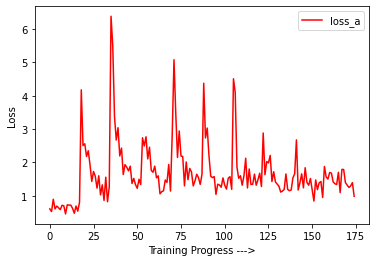

In [ ]:
lin_a = np.linspace(0, (len(loss_a_array)-1),175)
a_new_array = []
# print(loss_a_array[0])
for i in lin_a:
    # print(loss_a_array[int(i)])
    a_new_array.append(loss_a_array[int(i)])
print(np.array(loss_c_array).shape)
plt.plot(a_new_array,color = 'r', label = 'loss_a')
# plt.plot(loss_b_array,color = 'b', label = 'loss_b')
# plt.plot(loss_c_array,color = 'g', label = 'loss_c')
plt.xlabel("Training Progress --->")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("gdrive/My Drive/IISc Coding Test/Loss_a_component(96.03).jpg")

LOSS B

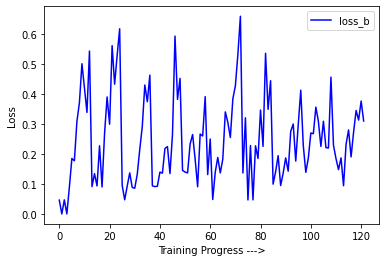

In [ ]:
lin_b = np.linspace(0, (len(loss_b_array)-1),122)
b_new_array = []
# print(loss_a_array[0])
for i in lin_b:
    # print(loss_a_array[int(i)])
    b_new_array.append(loss_b_array[int(i)])

plt.plot(b_new_array,color = 'b', label = 'loss_b')
# plt.plot(loss_b_array,color = 'b', label = 'loss_b')
# plt.plot(loss_c_array,color = 'g', label = 'loss_c')
plt.xlabel("Training Progress --->")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("gdrive/My Drive/IISc Coding Test/Loss_a_component(96.03).jpg")

LOSS C

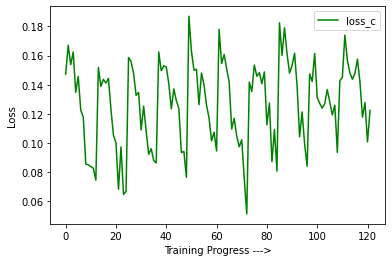

In [ ]:
lin_c = np.linspace(0, (len(loss_b_array)-1),122)
c_new_array = []
# print(loss_a_array[0])
for i in lin_c:
    # print(loss_a_array[int(i)])
    c_new_array.append(loss_c_array[int(i)])

plt.plot(c_new_array,color = 'g', label = 'loss_c')
# plt.plot(loss_b_array,color = 'b', label = 'loss_b')
# plt.plot(loss_c_array,color = 'g', label = 'loss_c')
plt.xlabel("Training Progress --->")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("gdrive/My Drive/IISc Coding Test/Loss_a_component(96.03).jpg")

In [ ]:
running_corrects_test = 0
phase = "test"
for input_test_final, label_test_final in test_ds:
    input_test_final = input_test_final.float().to(device)
    label_test_final = label_test_final.to(device)
    # print("validation:",iter_valid)
    outputs_test_final = model(input_test_final)
    _, preds_test_final = torch.max(outputs_test_final, 1)
    running_corrects_test += torch.sum(preds_test_final == label_test_final)

epoch_acc_test = running_corrects_test*1.0 / dataset_sizes[phase]
print(epoch_acc_test)

tensor(0.1773, device='cuda:0')
